In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.xception import Xception

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

In [3]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, img_size = 299,
                                               mean_proc=None, test_size=0.2)

# Xception Fine Tuning

In [4]:
model_name = 'Xception-Fine-Tune'

img_rows, img_cols, img_channel = 299, 299, 3
base_model = Xception(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [5]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 10
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop])

Epoch 1/100
42/43 [============================>.] - ETA: 0s - loss: 2.7604 - acc: 0.0452
Epoch 00001: val_loss improved from inf to 2.59479, saving model to ./saved_models/Xception-Fine-Tune.h5
43/43 [==============================] - 34s 787ms/step - loss: 2.7550 - acc: 0.0465 - val_loss: 2.5948 - val_acc: 0.1389
Epoch 2/100
42/43 [============================>.] - ETA: 0s - loss: 2.5827 - acc: 0.1095
Epoch 00002: val_loss improved from 2.59479 to 2.47881, saving model to ./saved_models/Xception-Fine-Tune.h5
43/43 [==============================] - 13s 307ms/step - loss: 2.5812 - acc: 0.1093 - val_loss: 2.4788 - val_acc: 0.2037
Epoch 3/100
42/43 [============================>.] - ETA: 0s - loss: 2.4113 - acc: 0.2214
Epoch 00003: val_loss improved from 2.47881 to 2.35994, saving model to ./saved_models/Xception-Fine-Tune.h5
43/43 [==============================] - 13s 310ms/step - loss: 2.4044 - acc: 0.2279 - val_loss: 2.3599 - val_acc: 0.2315
Epoch 4/100
42/43 [======================

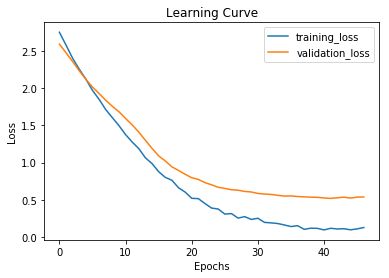

In [6]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

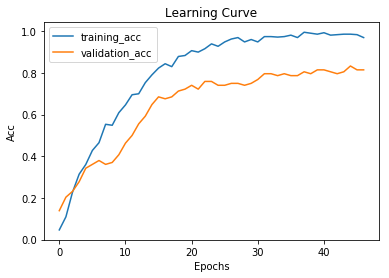

In [7]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [8]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc=None, img_size=299)

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./{}.csv'.format(model_name), index=False)

108/108 [==============================] - 2s 19ms/step
Validation loss: 0.517121156056722
Validation accuracy: 0.805555557763135
